In [1]:
from TopoAnalysis import dem as d
import matplotlib.pylab as plt
from TopoAnalysis.plotting import plot_recursive_upstream_profiles
import numpy as np
import os
import pandas as pd

In [2]:
new_directory_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata'  
os.chdir(new_directory_path)
print("New working directory:", os.getcwd())

New working directory: /Users/Glong1/Desktop/Andes/Andes_watersheds/MataquitoRiver/30DEMwatersheddata


In [5]:
area = d.Area.load('area_utm30m')
print('area loaded')
fd = d.FlowDirectionD8.load('fd_utm30m')
print('fd loaded')
elevation = d.Elevation.load('dem_utm30m.tif')
print('elevation loaded')

area loaded
fd loaded
elevation loaded


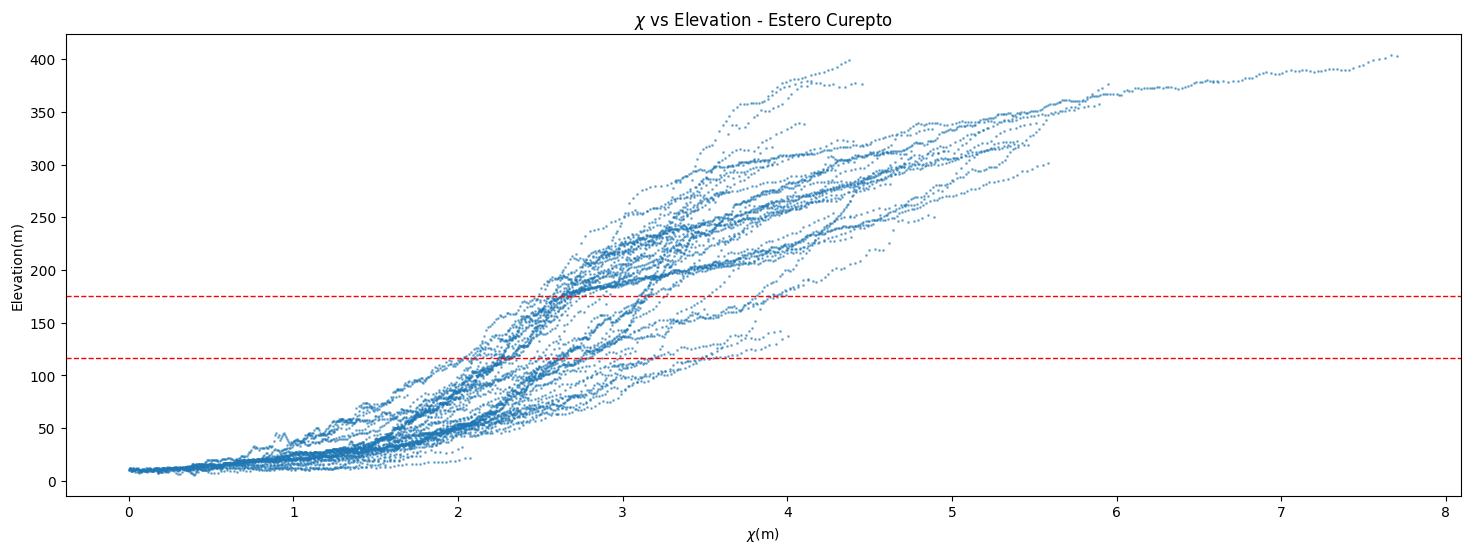

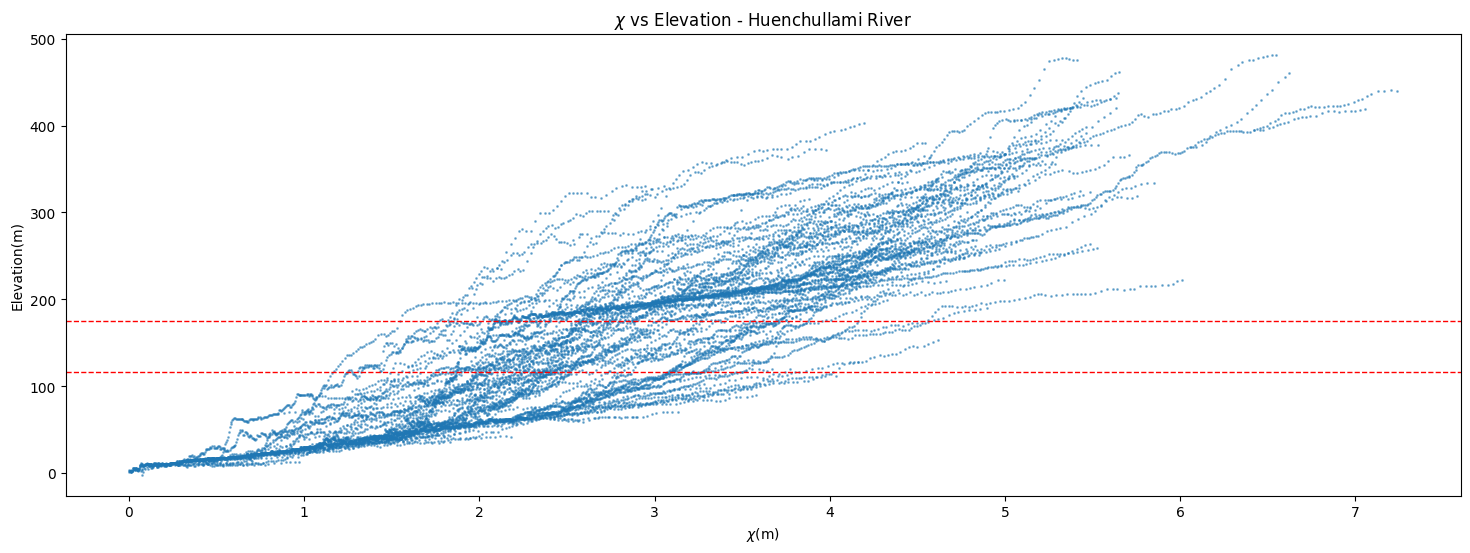

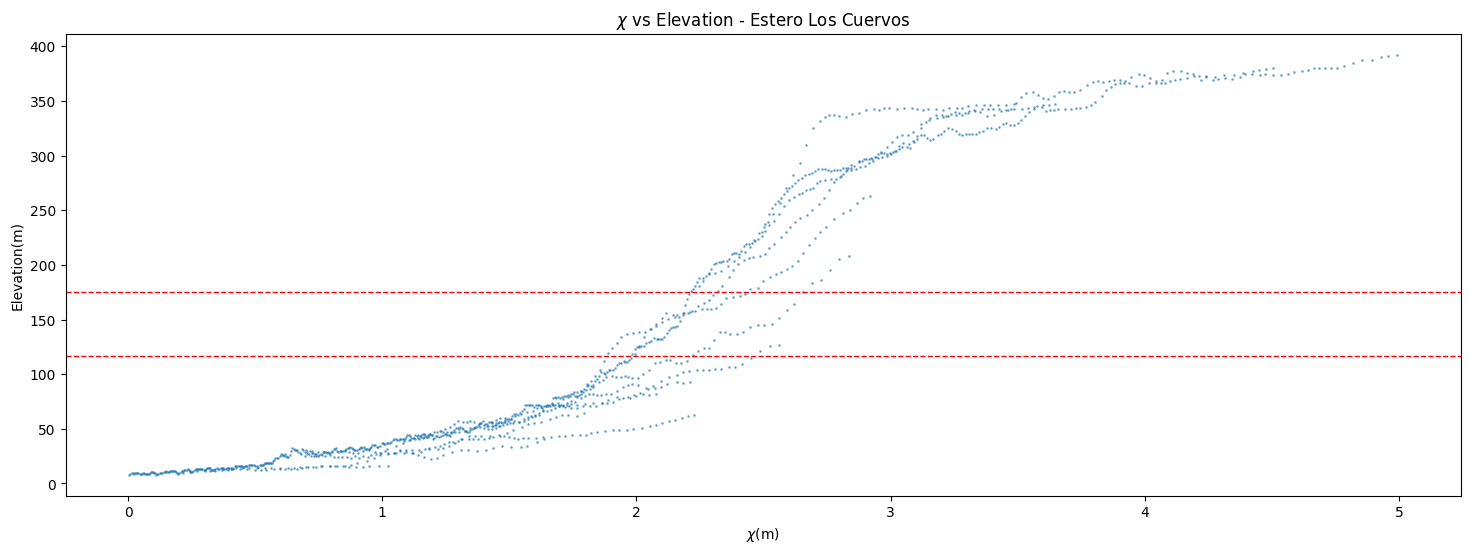

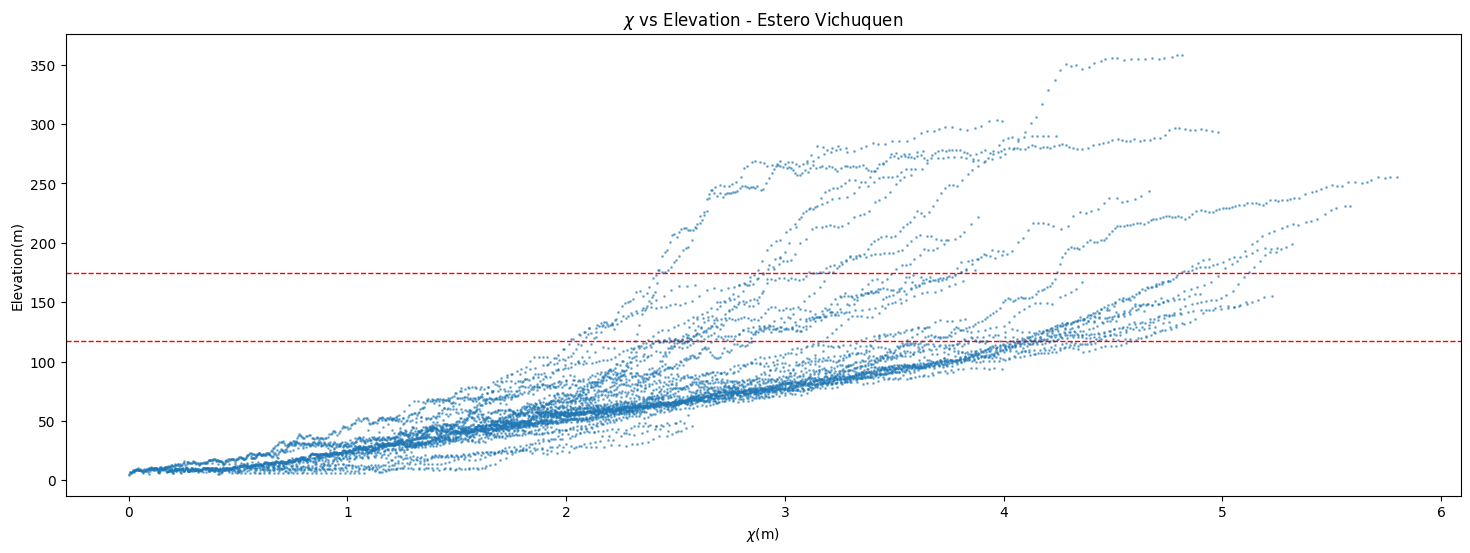

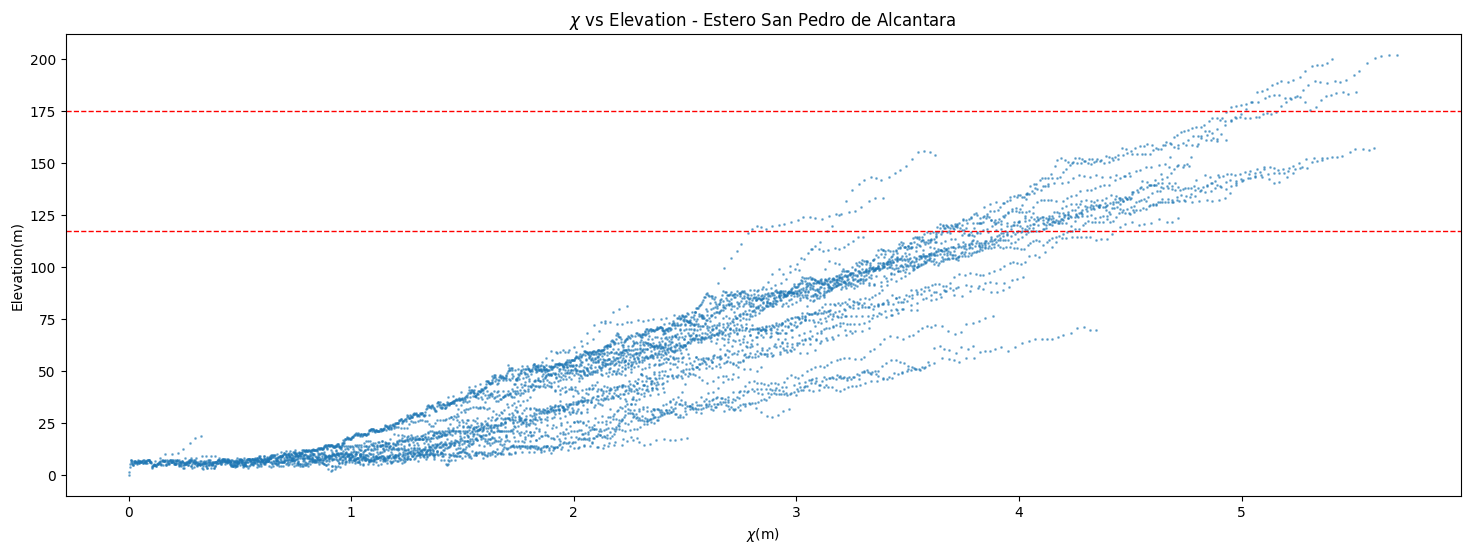

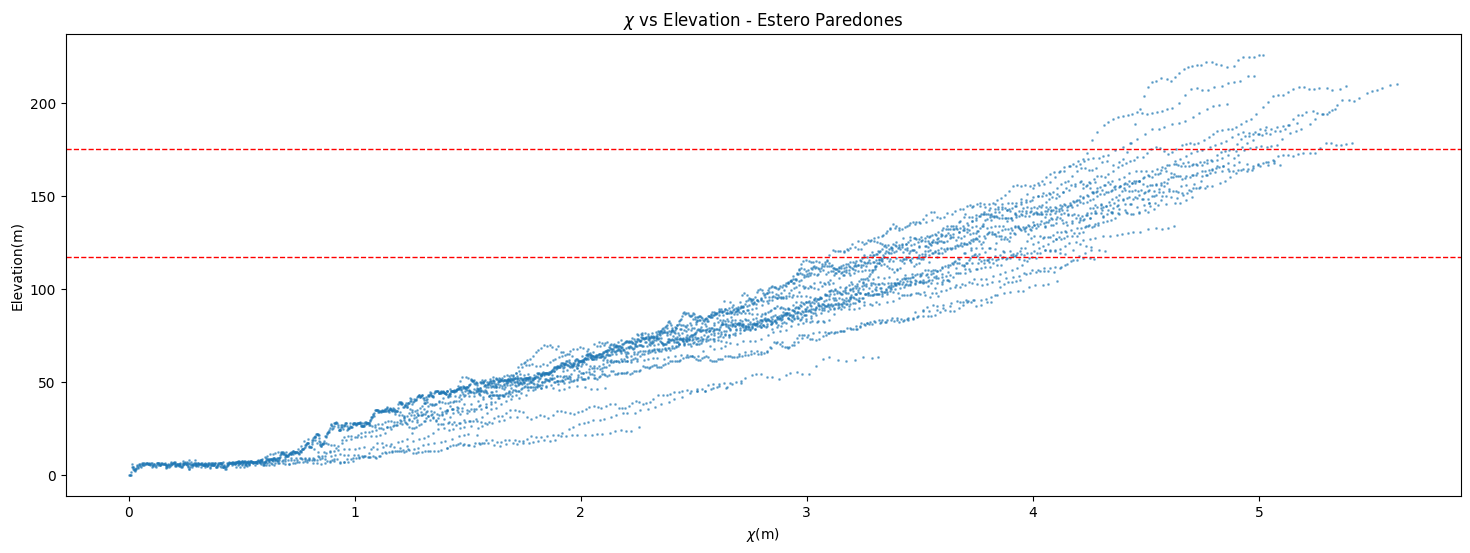

In [16]:
# Define your single outlet point
outlets = [(220105, 6117333),
           (207214, 6108725),
           (211126, 6118233),
           (223394, 6139757),
           (220209, 6157379),
           (221083, 6162719)
           
]
samples = [('Estero Curepto'),
           ('Huenchullami River'),
           ('Estero Los Cuervos'),
           ('Estero Vichuquen'),
           ('Estero San Pedro de Alcantara'),
           ('Estero Paredones')
]

for i, (outlet, sample) in enumerate(zip(outlets, samples)):
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.5, Ao=1, outlets=[outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6  # 1 km^2 in m^2
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    plt.axhline(y=117, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=175, color='red', linestyle='--', linewidth=1)
    plt.xlabel('$\\chi$(m)')
    plt.ylabel('Elevation(m)')
    plt.title(f'$\\chi$ vs Elevation - {sample}')
    #plt.savefig(f'Figures/chi_elevation_plot_{sample}.png', bbox_inches='tight', pad_inches=0.1)  # Unique filename for each
    plt.show()

## Full river profile analysis
Following Perron and Royden (2013)

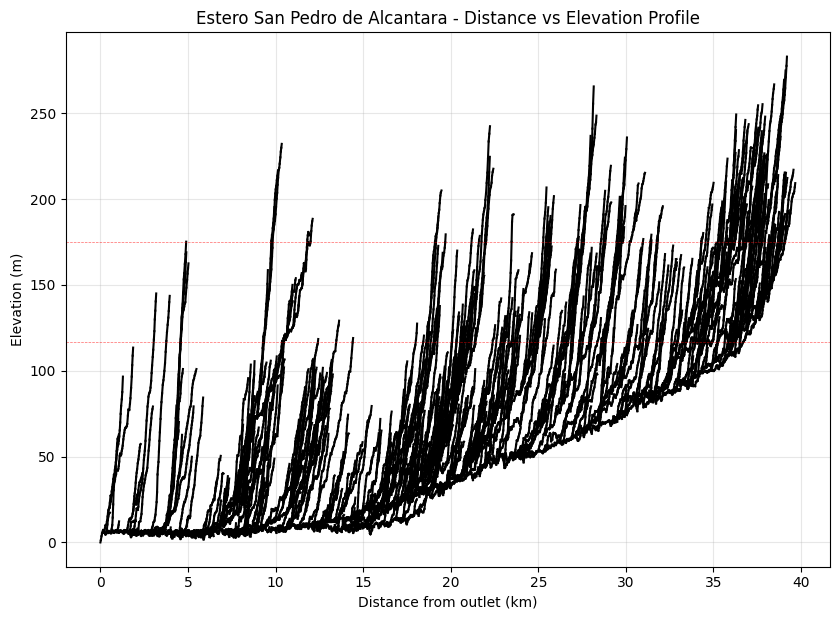

Testing theta values for Estero San Pedro de Alcantara...
Optimal theta (m/n): 0.400
Maximum R²: 0.8917


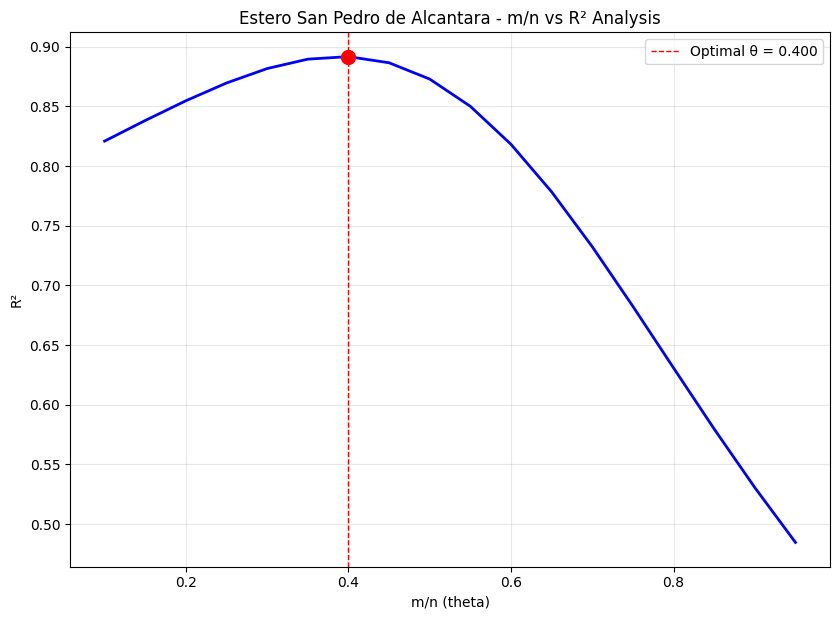

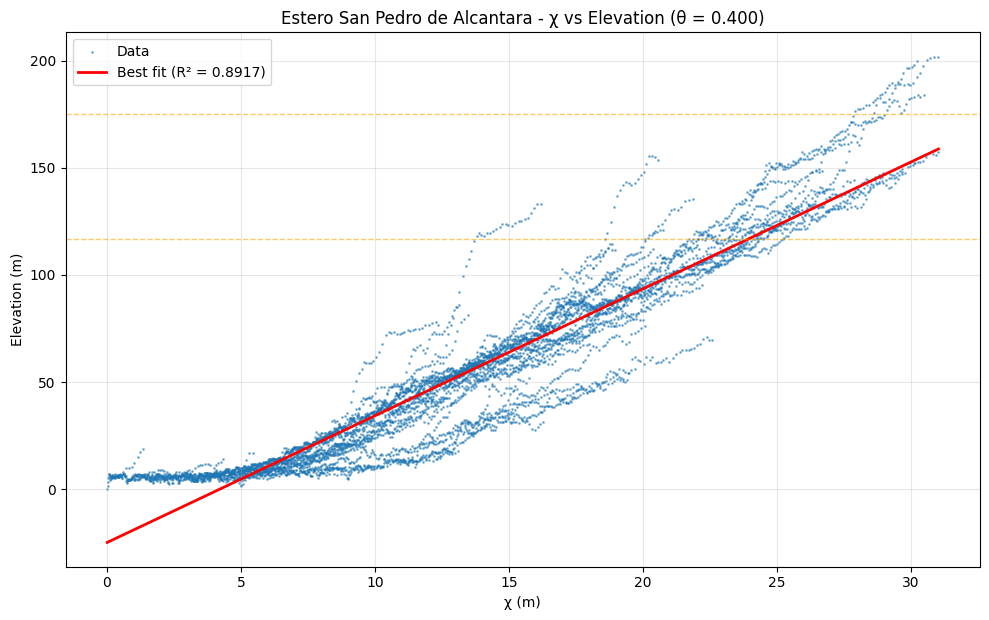


Analysis complete for Estero San Pedro de Alcantara
Optimal m/n ratio: 0.400
Chi-elevation R²: 0.8917


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Your existing helper functions
def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Single outlet for Estero Curepto
outlet = (220209, 6157379)
sample = 'Estero San Pedro de Alcantara'




# ============================================================================
# PART 1: Distance vs Elevation Profile
# ============================================================================
fig, ax = plt.subplots(1, figsize=(8.5, 6.3))

ld_list = fd.map_values_to_recursive_list(
    outlet, 
    elevation=elevation, 
    area=area, 
    de=mean_pixel_dimension
)
fix_indices_recursive(ld_list)

plot_upstream_profile(ld_list, minimum_area=1E5)

ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
ax.axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

ax.grid(True, alpha=0.3)
ax.set_xlabel('Distance from outlet (km)')
ax.set_ylabel('Elevation (m)')
ax.set_title(f'{sample} - Distance vs Elevation Profile')
plt.tight_layout()
plt.show()

# ============================================================================
# PART 2: m/n (theta) vs R² Analysis
# ============================================================================
# Test different theta values (m/n ratios)
theta_values = np.arange(0.1, 1.0, 0.05)  # From 0.1 to 0.95 in steps of 0.05
r_squared_values = []

print(f"Testing theta values for {sample}...")

for theta in theta_values:
    # Calculate chi with this theta value
    chi_test = d.Chi(flow_direction=fd, area=area, theta=theta, Ao=1, outlets=[outlet])
    
    chi_data = chi_test._griddata[chi_test._griddata > 0]
    elev_data = elevation._griddata[chi_test._griddata > 0]
    area_data = area._griddata[chi_test._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    
    chi_masked = chi_data[mask_out]
    elev_masked = elev_data[mask_out]
    
    # Calculate R² for linear fit
    if len(chi_masked) > 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(chi_masked, elev_masked)
        r_squared_values.append(r_value**2)
    else:
        r_squared_values.append(0)

# Find optimal theta (maximum R²)
optimal_idx = np.argmax(r_squared_values)
optimal_theta = theta_values[optimal_idx]
optimal_r2 = r_squared_values[optimal_idx]

print(f"Optimal theta (m/n): {optimal_theta:.3f}")
print(f"Maximum R²: {optimal_r2:.4f}")

# Plot m/n vs R²
fig, ax = plt.subplots(1, figsize=(8.5, 6.3))
ax.plot(theta_values, r_squared_values, 'b-', linewidth=2)
ax.axvline(x=optimal_theta, color='red', linestyle='--', linewidth=1, 
           label=f'Optimal θ = {optimal_theta:.3f}')
ax.scatter([optimal_theta], [optimal_r2], color='red', s=100, zorder=5)

ax.grid(True, alpha=0.3)
ax.set_xlabel('m/n (theta)')
ax.set_ylabel('R²')
ax.set_title(f'{sample} - m/n vs R² Analysis')
ax.legend()
plt.tight_layout()
plt.show()

# ============================================================================
# PART 3: Chi-Elevation Plot with Optimal Theta
# ============================================================================
chi_optimal = d.Chi(flow_direction=fd, area=area, theta=optimal_theta, Ao=1, outlets=[outlet])

chi_data = chi_optimal._griddata[chi_optimal._griddata > 0]
elev_data = elevation._griddata[chi_optimal._griddata > 0]
area_data = area._griddata[chi_optimal._griddata > 0]

mask_out = area_data >= 1e6

# Calculate best-fit line for the plot
chi_masked = chi_data[mask_out]
elev_masked = elev_data[mask_out]
slope, intercept, r_value, p_value, std_err = stats.linregress(chi_masked, elev_masked)

fig, ax = plt.subplots(1, figsize=(10, 6.3))
ax.scatter(chi_masked, elev_masked, s=1, alpha=0.5, label='Data')

# Plot best-fit line
chi_line = np.array([chi_masked.min(), chi_masked.max()])
elev_line = slope * chi_line + intercept
ax.plot(chi_line, elev_line, 'r-', linewidth=2, 
        label=f'Best fit (R² = {r_value**2:.4f})')

ax.axhline(y=175, color='orange', linestyle='--', linewidth=1, alpha=0.6)
ax.axhline(y=117, color='orange', linestyle='--', linewidth=1, alpha=0.6)

ax.grid(True, alpha=0.3)
ax.set_xlabel('χ (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title(f'{sample} - χ vs Elevation (θ = {optimal_theta:.3f})')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nAnalysis complete for {sample}")
print(f"Optimal m/n ratio: {optimal_theta:.3f}")
print(f"Chi-elevation R²: {r_value**2:.4f}")

Creating distance-elevation profile for Estero Curepto...


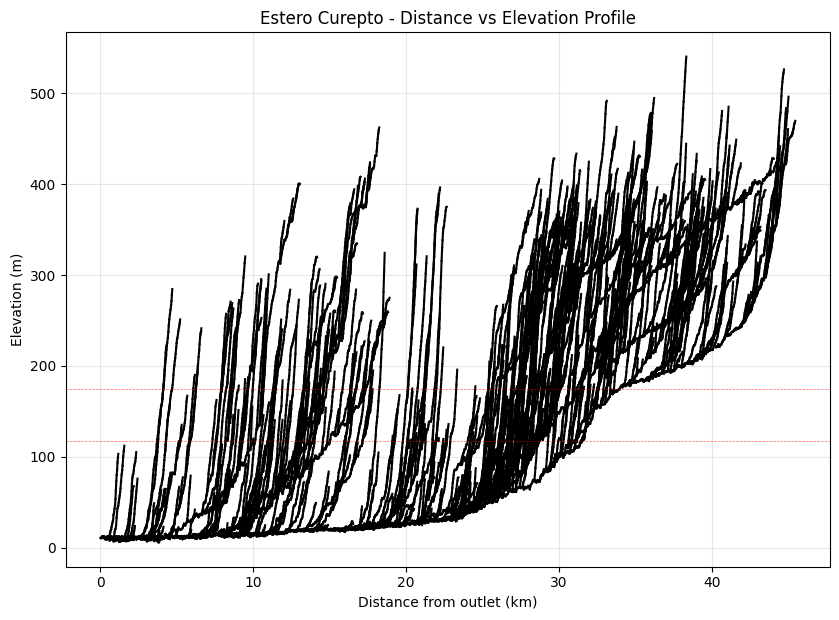

Calculating chi for entire watershed (this may take a moment)...
Extracting data for Estero Curepto...
Plotting chi-elevation for Estero Curepto...


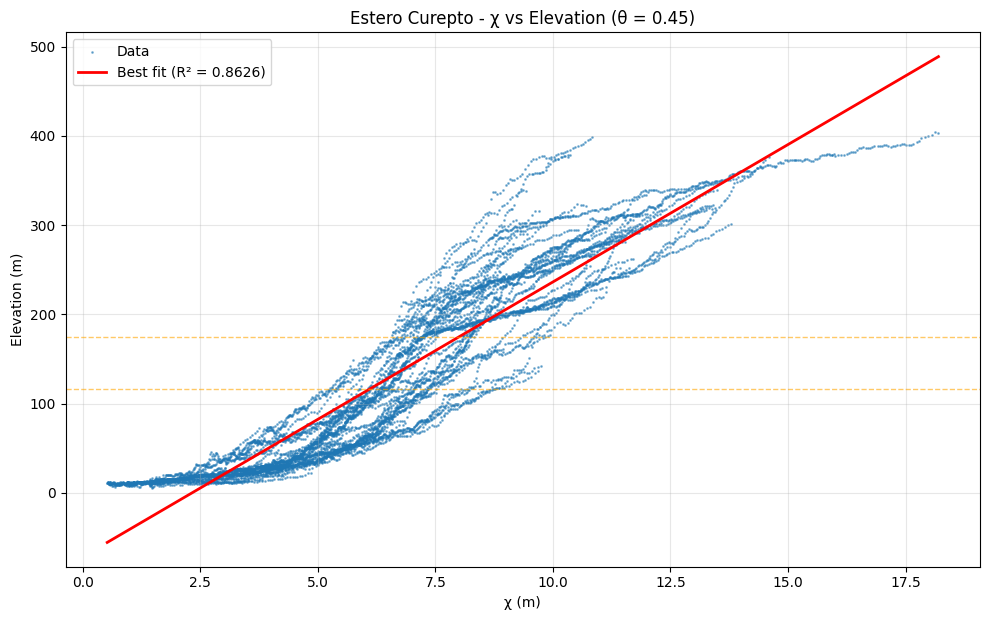


Analysis complete for Estero Curepto
Theta (m/n): 0.45
Chi-elevation R²: 0.8626
Slope (k_sn): 30.7892 m/m


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Your existing helper functions
def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Main outlet for the ENTIRE watershed (sets the chi reference frame)
main_outlet = (210856, 6117785)

# Specific point to zoom in on (Estero Curepto tributary)
focus_outlet = (220105, 6117333)
sample = 'Estero Curepto'

# Set theta value (m/n ratio) - you can adjust this
theta = 0.45

# ============================================================================
# PART 1: Distance vs Elevation Profile
# ============================================================================
print(f"Creating distance-elevation profile for {sample}...")

fig, ax = plt.subplots(1, figsize=(8.5, 6.3))

ld_list = fd.map_values_to_recursive_list(
    focus_outlet, 
    elevation=elevation, 
    area=area, 
    de=mean_pixel_dimension
)
fix_indices_recursive(ld_list)

plot_upstream_profile(ld_list, minimum_area=1E5)

ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
ax.axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

ax.grid(True, alpha=0.3)
ax.set_xlabel('Distance from outlet (km)')
ax.set_ylabel('Elevation (m)')
ax.set_title(f'{sample} - Distance vs Elevation Profile')
plt.tight_layout()
plt.show()

# ============================================================================
# PART 2: Chi-Elevation Plot
# ============================================================================
print(f"Calculating chi for entire watershed (this may take a moment)...")

# Calculate chi for ENTIRE WATERSHED using the main outlet
chi_map = d.Chi(flow_direction=fd, area=area, theta=theta, Ao=1, outlets=[main_outlet])

print(f"Extracting data for {sample}...")

# Get the river network for our FOCUS outlet (the tributary we want to zoom in on)
ld_list = fd.map_values_to_recursive_list(focus_outlet, elevation=elevation, area=area)

# Extract indices from the river network
def get_indices_recursive(ld_item, indices_list):
    indices_list.append(ld_item['index'])
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            get_indices_recursive(next_item, indices_list)

indices = []
get_indices_recursive(ld_list, indices)

# Get chi and elevation values only for these indices
chi_subset = []
elev_subset = []
area_subset = []
for idx in indices:
    # Handle nested tuples: ((row, col),) should become (row, col)
    if isinstance(idx, tuple) and len(idx) == 1 and isinstance(idx[0], tuple):
        row, col = idx[0]  # Unwrap the nested tuple
    elif isinstance(idx, tuple) and len(idx) == 2:
        row, col = idx  # Already in correct format
    else:
        continue  # Skip any unexpected formats
    
    if chi_map._griddata[row, col] > 0:
        chi_subset.append(chi_map._griddata[row, col])
        elev_subset.append(elevation._griddata[row, col])
        area_subset.append(area._griddata[row, col])

chi_subset = np.array(chi_subset)
elev_subset = np.array(elev_subset)
area_subset = np.array(area_subset)

# Mask out areas less than 1 km^2
mask_out = area_subset >= 1e6
chi_masked = chi_subset[mask_out]
elev_masked = elev_subset[mask_out]

# Calculate best-fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(chi_masked, elev_masked)

print(f"Plotting chi-elevation for {sample}...")

fig, ax = plt.subplots(1, figsize=(10, 6.3))
ax.scatter(chi_masked, elev_masked, s=1, alpha=0.5, label='Data')

# Plot best-fit line
chi_line = np.array([chi_masked.min(), chi_masked.max()])
elev_line = slope * chi_line + intercept
ax.plot(chi_line, elev_line, 'r-', linewidth=2, 
        label=f'Best fit (R² = {r_value**2:.4f})')

ax.axhline(y=175, color='orange', linestyle='--', linewidth=1, alpha=0.6)
ax.axhline(y=117, color='orange', linestyle='--', linewidth=1, alpha=0.6)

ax.grid(True, alpha=0.3)
ax.set_xlabel('χ (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title(f'{sample} - χ vs Elevation (θ = {theta})')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nAnalysis complete for {sample}")
print(f"Theta (m/n): {theta}")
print(f"Chi-elevation R²: {r_value**2:.4f}")
print(f"Slope (k_sn): {slope:.4f} m/m")

In [24]:
# After calculating chi_map
print(f"Chi map statistics:")
print(f"  Total non-zero chi values in watershed: {np.sum(chi_map._griddata > 0)}")
print(f"  Max chi in watershed: {np.max(chi_map._griddata):.2f}")
print(f"  Min chi in watershed (>0): {np.min(chi_map._griddata[chi_map._griddata > 0]):.2f}")

# After extracting chi_subset
print(f"\nFocus outlet ({sample}) statistics:")
print(f"  Number of points extracted: {len(chi_subset)}")
print(f"  Max chi in this tributary: {np.max(chi_subset):.2f}")
print(f"  Min chi in this tributary: {np.min(chi_subset):.2f}")

# The key test: if it's really using the whole watershed, 
# the tributary chi values should be a SUBSET of the full range
print(f"\nIs tributary chi range smaller than watershed? {np.max(chi_subset) < np.max(chi_map._griddata)}")

Chi map statistics:
  Total non-zero chi values in watershed: 8836734
  Max chi in watershed: 58.59
  Min chi in watershed (>0): 0.00

Focus outlet (Estero Curepto) statistics:
  Number of points extracted: 595793
  Max chi in this tributary: 34.63
  Min chi in this tributary: 0.52

Is tributary chi range smaller than watershed? True
